# Sequence Modeling with RNNs and Transformers

In this tutorial, we'll build sequence models for tasks like text generation and time series prediction using RNNs, LSTMs, and attention mechanisms.

## Learning Objectives

By the end of this tutorial, you will be able to:
- Build RNN and LSTM models for sequence tasks
- Implement attention mechanisms
- Create a simple Transformer architecture
- Train models for text generation
- Handle variable-length sequences
- Implement teacher forcing and sampling strategies
- Visualize attention weights

## What We'll Build

We'll create:
- Character-level language model with RNN/LSTM
- Attention-based sequence-to-sequence model
- Simple Transformer for sequence modeling
- Text generation pipeline

In [183]:
import brainstate 
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Set random seed
brainstate.random.seed(42)

print(f"JAX devices: {jax.devices()}")

JAX devices: [CpuDevice(id=0)]


## 1. Dataset Preparation: Character-Level Text

In [184]:
# Sample text data
sample_text = """
The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog.
Neural networks are powerful tools for machine learning. Neural networks learn patterns from data.
Deep learning has revolutionized artificial intelligence. Deep learning uses multiple layers.
Transformers have become the dominant architecture for NLP. Transformers use attention mechanisms.
Attention is all you need for sequence modeling. Attention helps models focus on relevant information.
Recurrent neural networks process sequences step by step. RNNs maintain hidden states across time.
LSTMs solve the vanishing gradient problem in RNNs. LSTMs use gates to control information flow.
""" * 2  # Optimized data size for quick demo

class CharacterTokenizer:
    """Simple character-level tokenizer."""
    
    def __init__(self, text: str):
        # Get unique characters
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        
        # Create mappings
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
    
    def encode(self, text: str) -> np.ndarray:
        """Convert text to indices."""
        return np.array([self.char_to_idx[ch] for ch in text])
    
    def decode(self, indices: np.ndarray) -> str:
        """Convert indices to text."""
        return ''.join([self.idx_to_char[int(idx)] for idx in indices])

# Create tokenizer
tokenizer = CharacterTokenizer(sample_text)
encoded_text = tokenizer.encode(sample_text)

print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Characters: {''.join(tokenizer.chars[:20])}...")
print(f"\nOriginal text length: {len(sample_text)}")
print(f"Encoded length: {len(encoded_text)}")
print(f"\nSample encoding: {encoded_text[:20]}")
print(f"Decoded: {tokenizer.decode(encoded_text[:20])}")

Vocabulary size: 38
Characters: 
 .ADLMNPRSTabcdefgh...

Original text length: 1364
Encoded length: 1364

Sample encoding: [ 0 11 19 16  1 28 32 20 14 22  1 13 29 26 34 25  1 17 26 35]
Decoded: 
The quick brown fox


### Create Training Sequences

In [185]:
def create_sequences(data, seq_length):
    """Create input-target pairs for sequence prediction.
    
    Args:
        data: Encoded text data
        seq_length: Length of input sequences
        
    Returns:
        inputs: Array of shape (n_sequences, seq_length)
        targets: Array of shape (n_sequences, seq_length)
    """
    inputs = []
    targets = []
    
    for i in range(len(data) - seq_length):
        inputs.append(data[i:i+seq_length])
        targets.append(data[i+1:i+seq_length+1])
    
    return np.array(inputs), np.array(targets)

# Create sequences
seq_length = 20
X, y = create_sequences(encoded_text, seq_length)

# Split into train/val
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"\nExample sequence:")
print(f"Input:  {tokenizer.decode(X_train[0])}")
print(f"Target: {tokenizer.decode(y_train[0])}")

Training sequences: (1075, 20)
Validation sequences: (269, 20)

Example sequence:
Input:  
The quick brown fox
Target: The quick brown fox 


## 2. RNN Language Model

In [186]:
class RNNLanguageModel(brainstate.nn.Module):
    """Simple RNN for character-level language modeling."""
    
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        
        # Embedding layer
        self.embedding = brainstate.ParamState(
            brainstate.random.randn(vocab_size, embedding_dim) * 0.1
        )
        
        # RNN cell
        self.rnn_cell = brainstate.nn.ValinaRNNCell(num_in=embedding_dim, num_out=hidden_dim)
        
        # Output projection
        self.fc_out = brainstate.nn.Linear(hidden_dim, vocab_size)
    
    def __call__(self, x, hidden=None):
        """Forward pass.
        
        Args:
            x: Input indices of shape (batch, seq_len)
            hidden: Initial hidden state
            
        Returns:
            logits: Output logits of shape (batch, seq_len, vocab_size)
            hidden: Final hidden state
        """
        batch_size, seq_len = x.shape
        
        # Initialize hidden state if not provided
        self.rnn_cell.init_state(batch_size=batch_size)
        
        # Embed input
        embedded = self.embedding.value[x]  # (batch, seq_len, embedding_dim)
        
        # Process sequence
        outputs = []
        for t in range(seq_len):
            hidden = self.rnn_cell.update(embedded[:, t, :])
            outputs.append(hidden)
        
        # Stack outputs
        outputs = jnp.stack(outputs, axis=1)  # (batch, seq_len, hidden_dim)
        
        # Project to vocabulary
        logits = jax.vmap(self.fc_out)(outputs)  # (batch, seq_len, vocab_size)
        
        return logits, hidden

# Create model
rnn_model = RNNLanguageModel(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=64,
    hidden_dim=128
)

# Test forward pass
test_input = jnp.array(X_train[:4])
test_logits, test_hidden = rnn_model(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Logits shape: {test_logits.shape}")
print(f"Hidden shape: {test_hidden.shape}")

# Count parameters
# n_params = sum(p.value.size for p in rnn_model.states(brainstate.ParamState).values())
n_params = 0
for p in rnn_model.states(brainstate.ParamState).values():
    if isinstance(p.value,dict):
        for v in p.value.values():
            n_params +=v.size
    else:
        n_params += p.value.size

print(f"\nTotal parameters: {n_params:,}")

Input shape: (4, 20)
Logits shape: (4, 20, 38)
Hidden shape: (4, 128)

Total parameters: 32,038


## 3. LSTM Language Model

In [187]:
class LSTMLanguageModel(brainstate.nn.Module):
    """LSTM for character-level language modeling."""
    
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        
        # Embedding layer
        self.embedding = brainstate.ParamState(
            brainstate.random.randn(vocab_size, embedding_dim) * 0.1
        )
        
        # LSTM cell
        self.lstm_cell = brainstate.nn.LSTMCell(num_in=embedding_dim, num_out=hidden_dim)
        
        # Output projection
        self.fc_out = brainstate.nn.Linear(hidden_dim, vocab_size)
    
    def __call__(self, x, state=None):
        """Forward pass.
        
        Args:
            x: Input indices of shape (batch, seq_len)
            state: Initial (hidden, cell) state tuple
            
        Returns:
            logits: Output logits of shape (batch, seq_len, vocab_size)
            state: Final (hidden, cell) state
        """
        batch_size, seq_len = x.shape
        
    
        # Initialize LSTM cell state
        self.lstm_cell.init_state(batch_size=batch_size)
        
        # Embed input
        embedded = self.embedding.value[x]  # (batch, seq_len, embedding_dim)
        
        # Process sequence
        outputs = []
        for t in range(seq_len):
            hidden = self.lstm_cell.update(embedded[:, t, :])
            outputs.append(hidden)
        
        # Stack outputs
        outputs = jnp.stack(outputs, axis=1)  # (batch, seq_len, hidden_dim)
        
        # Project to vocabulary
        logits = jax.vmap(self.fc_out)(outputs)  # (batch, seq_len, vocab_size)
        
        return logits, (self.lstm_cell.h.value, self.lstm_cell.c.value)

# Create LSTM model
lstm_model = LSTMLanguageModel(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=64,
    hidden_dim=128
)

# Test forward pass
test_logits, test_state = lstm_model(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Logits shape: {test_logits.shape}")
print(f"Hidden state shape: {test_state[0].shape}")
print(f"Cell state shape: {test_state[1].shape}")

# n_params = sum(p.value.size for p in lstm_model.states(brainstate.ParamState).values())
n_params = 0
for p in lstm_model.states(brainstate.ParamState).values():
    if isinstance(p.value,dict):
        for v in p.value.values():
            n_params +=v.size
    else:
        n_params += p.value.size

print(f"\nTotal parameters: {n_params:,}")

Input shape: (4, 20)
Logits shape: (4, 20, 38)
Hidden state shape: (4, 128)
Cell state shape: (4, 128)

Total parameters: 106,150


## 4. Training Setup

In [188]:
def cross_entropy_loss(logits, targets):
    """Compute cross-entropy loss for sequences.
    
    Args:
        logits: Predicted logits of shape (batch, seq_len, vocab_size)
        targets: True indices of shape (batch, seq_len)
        
    Returns:
        Scalar loss value
    """
    batch_size, seq_len, vocab_size = logits.shape
    
    # Reshape for easier computation
    logits_flat = logits.reshape(-1, vocab_size)
    targets_flat = targets.reshape(-1)
    
    # One-hot encode targets
    one_hot = jax.nn.one_hot(targets_flat, vocab_size)
    
    # Compute log probabilities
    log_probs = jax.nn.log_softmax(logits_flat, axis=-1)
    
    # Compute loss
    loss = -jnp.mean(jnp.sum(one_hot * log_probs, axis=-1))
    
    return loss

def perplexity(loss):
    """Compute perplexity from loss."""
    return jnp.exp(loss)

def train_step(model, x_batch, y_batch, learning_rate=0.001):
    """Perform one training step."""
    with brainstate.environ.context(fit=True):
        def loss_fn():
            logits, _ = model(jnp.array(x_batch))
            return cross_entropy_loss(logits, jnp.array(y_batch))
        
        # Compute gradients
        grads,loss = brainstate.transform.grad(
            loss_fn,
            model.states(brainstate.ParamState),
            return_value=True
        )()
        
        # Update parameters
        for name, param_state in model.states(brainstate.ParamState).items():
            grad_value = grads[name]
            # Handle nested dict structure
            if isinstance(param_state.value, dict):
                for key in param_state.value.keys():
                    param_state.value[key] -= learning_rate * grad_value[key]
            else:
                param_state.value -= learning_rate * grad_value
        return float(loss)

def eval_step(model, x_batch, y_batch):
    """Perform one evaluation step."""
    with brainstate.environ.context(fit=False):
        logits, _ = model(jnp.array(x_batch))
        loss = cross_entropy_loss(logits, jnp.array(y_batch))
        return float(loss)

# Test training step
batch_size = 32
x_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

initial_loss = eval_step(lstm_model, x_batch, y_batch)
print(f"Initial loss: {initial_loss:.4f}")
print(f"Initial perplexity: {perplexity(initial_loss):.2f}")

Initial loss: 3.6380
Initial perplexity: 38.02


## 5. Train LSTM Model

In [189]:
def train_epoch(model, X, y, batch_size, learning_rate):
    """Train for one epoch."""
    losses = []
    n_samples = len(X)
    
    # Shuffle data
    indices = np.random.permutation(n_samples)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_indices = indices[start_idx:end_idx]
        
        x_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        loss = train_step(model, x_batch, y_batch, learning_rate)
        losses.append(loss)
    
    return np.mean(losses)

def evaluate(model, X, y, batch_size):
    """Evaluate model."""
    losses = []
    n_samples = len(X)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        x_batch = X[start_idx:end_idx]
        y_batch = y[start_idx:end_idx]
        
        loss = eval_step(model, x_batch, y_batch)
        losses.append(loss)
    
    return np.mean(losses)

# Training configuration
config = {
    'num_epochs': 150,
    'batch_size': 32,
    'learning_rate': 0.01,
}

# Create fresh model
model = LSTMLanguageModel(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=32,
    hidden_dim=64
)

# Training loop
history = {'train_loss': [], 'val_loss': []}

print("Training LSTM Language Model")
print("=" * 60)

for epoch in range(config['num_epochs']):
    # Train
    train_loss = train_epoch(
        model, X_train, y_train,
        config['batch_size'],
        config['learning_rate']
    )
    
    # Validate
    val_loss = evaluate(model, X_val, y_val, config['batch_size'])
    
    # Record history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    # Print progress
    if epoch % 5 == 0 or epoch == config['num_epochs'] - 1:
        print(f"Epoch {epoch:3d}: "
              f"train_loss={train_loss:.4f} (ppl={perplexity(train_loss):.2f}), "
              f"val_loss={val_loss:.4f} (ppl={perplexity(val_loss):.2f})")

print("=" * 60)
print("Training completed!")

Training LSTM Language Model
Epoch   0: train_loss=3.6247 (ppl=37.51), val_loss=3.6086 (ppl=36.92)
Epoch   5: train_loss=3.4922 (ppl=32.86), val_loss=3.4787 (ppl=32.42)
Epoch  10: train_loss=3.3774 (ppl=29.29), val_loss=3.3657 (ppl=28.95)
Epoch  15: train_loss=3.2904 (ppl=26.85), val_loss=3.2788 (ppl=26.54)
Epoch  20: train_loss=3.2301 (ppl=25.28), val_loss=3.2162 (ppl=24.93)
Epoch  25: train_loss=3.1910 (ppl=24.31), val_loss=3.1740 (ppl=23.90)
Epoch  30: train_loss=3.1667 (ppl=23.73), val_loss=3.1468 (ppl=23.26)
Epoch  35: train_loss=3.1507 (ppl=23.35), val_loss=3.1296 (ppl=22.86)
Epoch  40: train_loss=3.1413 (ppl=23.13), val_loss=3.1184 (ppl=22.61)
Epoch  45: train_loss=3.1334 (ppl=22.95), val_loss=3.1108 (ppl=22.44)
Epoch  50: train_loss=3.1282 (ppl=22.83), val_loss=3.1054 (ppl=22.32)
Epoch  55: train_loss=3.1239 (ppl=22.73), val_loss=3.1013 (ppl=22.23)
Epoch  60: train_loss=3.1202 (ppl=22.65), val_loss=3.0980 (ppl=22.15)
Epoch  65: train_loss=3.1171 (ppl=22.58), val_loss=3.0952 (pp

### Visualize Training

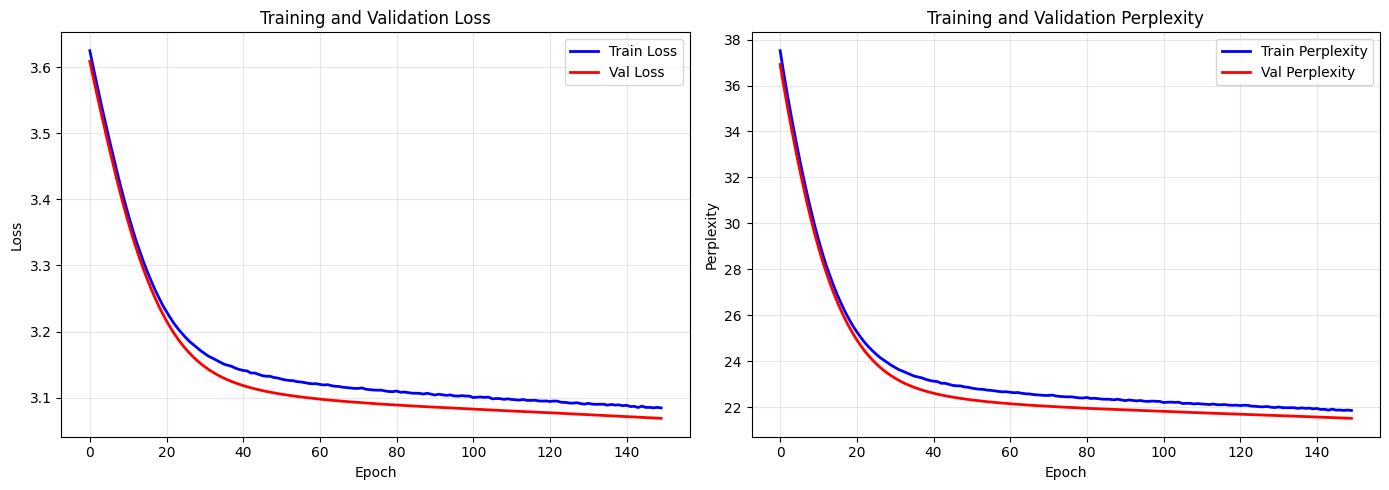

In [190]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(len(history['train_loss']))

# Loss
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Perplexity
train_ppl = [perplexity(loss) for loss in history['train_loss']]
val_ppl = [perplexity(loss) for loss in history['val_loss']]

ax2.plot(epochs, train_ppl, 'b-', label='Train Perplexity', linewidth=2)
ax2.plot(epochs, val_ppl, 'r-', label='Val Perplexity', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.set_title('Training and Validation Perplexity')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Text Generation

In [191]:
def generate_text(model, start_text, length=100, temperature=1.0):
    """Generate text using the trained model.
    
    Args:
        model: Trained language model
        start_text: Starting string
        length: Number of characters to generate
        temperature: Sampling temperature (higher = more random)
        
    Returns:
        Generated text string
    """
    # Encode start text
    current_seq = tokenizer.encode(start_text)
    generated = list(current_seq)
    
    with brainstate.environ.context(fit=False):
        state = None
        
        for _ in range(length):
            # Prepare input (last seq_length characters)
            input_seq = current_seq[-seq_length:]
            input_seq = jnp.array(input_seq).reshape(1, -1)
            
            # Pad if necessary
            if input_seq.shape[1] < seq_length:
                pad_length = seq_length - input_seq.shape[1]
                padding = jnp.zeros((1, pad_length), dtype=jnp.int32)
                input_seq = jnp.concatenate([padding, input_seq], axis=1)
            
            # Get predictions
            logits, state = model(input_seq, state)
            
            # Get last time step
            last_logits = logits[0, -1, :] / temperature
            
            # Sample from distribution
            probs = jax.nn.softmax(last_logits)
            next_idx = np.random.choice(len(probs), p=np.array(probs))
            
            # Append to sequence
            generated.append(next_idx)
            current_seq = np.append(current_seq, next_idx)
    
    return tokenizer.decode(np.array(generated))

# Generate samples with different temperatures
start_text = "The "
temperatures = [0.5, 1.0]

print("\nGenerated Text Samples:")
print("=" * 70)

for temp in temperatures:
    generated = generate_text(model, start_text, length=100, temperature=temp)
    print(f"\nTemperature = {temp}:")
    print(generated)
    print("-" * 70)



Generated Text Samples:

Temperature = 0.5:
The mso  aseool eelr aor eefcne e  metelnoaeor  eirm  ioea imroep  oehrss ll eenis ln nicue ie coai
 o r
----------------------------------------------------------------------

Temperature = 1.0:
The cao e aLrmsylu  i tktandlscijnr l.Ni  aiaestlxo posime nu..esmisNuurdee.  nv n mg erTibttoolrwur sml
----------------------------------------------------------------------


## 7. Attention Mechanism

In [192]:
class ScaledDotProductAttention(brainstate.nn.Module):
    """Scaled dot-product attention mechanism."""
    
    def __init__(self, dim):
        super().__init__()
        self.scale = jnp.sqrt(dim)
    
    def __call__(self, query, key, value, mask=None):
        """Compute attention.
        
        Args:
            query: Query tensor of shape (batch, seq_len_q, dim)
            key: Key tensor of shape (batch, seq_len_k, dim)
            value: Value tensor of shape (batch, seq_len_v, dim)
            mask: Optional mask
            
        Returns:
            output: Attended values
            attention_weights: Attention weights
        """
        # Compute attention scores
        scores = jnp.matmul(query, key.transpose(0, 2, 1)) / self.scale
        
        # Apply mask if provided
        if mask is not None:
            scores = jnp.where(mask, scores, -1e9)
        
        # Compute attention weights
        attention_weights = jax.nn.softmax(scores, axis=-1)
        
        # Apply attention to values
        output = jnp.matmul(attention_weights, value)
        
        return output, attention_weights

class AttentionLSTM(brainstate.nn.Module):
    """LSTM with self-attention."""
    
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        
        # Embedding
        self.embedding = brainstate.ParamState(
            brainstate.random.randn(vocab_size, embedding_dim) * 0.1
        )
        
        # LSTM
        self.lstm_cell = brainstate.nn.LSTMCell(num_in=embedding_dim, num_out=hidden_dim)
        
        # Attention
        self.attention = ScaledDotProductAttention(hidden_dim)
        
        # Output
        self.fc_out = brainstate.nn.Linear(hidden_dim * 2, vocab_size)
    
    def __call__(self, x):
        """Forward pass with attention."""
        batch_size, seq_len = x.shape
        
        # Embed
        embedded = self.embedding.value[x]
        
        # LSTM processing
        self.lstm_cell.init_state(batch_size=batch_size)
        
        lstm_outputs = []
        for t in range(seq_len):
            hidden = self.lstm_cell.update(embedded[:, t, :])
            lstm_outputs.append(hidden)
        
        lstm_outputs = jnp.stack(lstm_outputs, axis=1)
        
        # Self-attention
        attended, attn_weights = self.attention(
            lstm_outputs, lstm_outputs, lstm_outputs
        )
        
        # Concatenate LSTM output and attended output
        combined = jnp.concatenate([lstm_outputs, attended], axis=-1)
        
        # Output projection
        logits = jax.vmap(self.fc_out)(combined)
        
        return logits, attn_weights

# Create attention model
attn_model = AttentionLSTM(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=64,
    hidden_dim=128
)

# Test
test_logits, test_attn = attn_model(test_input)
print(f"Logits shape: {test_logits.shape}")
print(f"Attention weights shape: {test_attn.shape}")

n_params = 0
for p in attn_model.states(brainstate.ParamState).values():
    if isinstance(p.value, dict):
        for v in p.value.values():
            n_params += v.size
    else:
        n_params += p.value.size
print(f"\nTotal parameters: {n_params:,}")

Logits shape: (4, 20, 38)
Attention weights shape: (4, 20, 20)

Total parameters: 111,014


### Visualize Attention

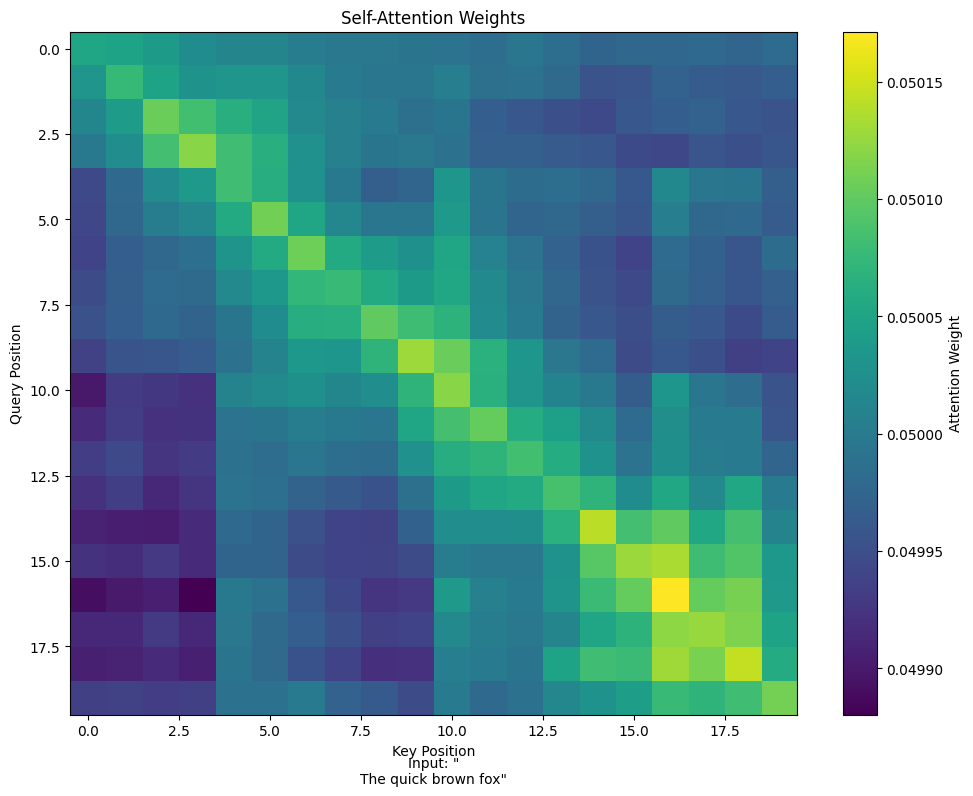

In [193]:
# Get attention weights for a sample
sample_input = jnp.array(X_train[0:1])  # Single sequence

with brainstate.environ.context(fit=False):
    _, attn_weights = attn_model(sample_input)

# Plot attention heatmap
plt.figure(figsize=(10, 8))
plt.imshow(attn_weights[0], cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Self-Attention Weights')

# Add text labels
input_text = tokenizer.decode(X_train[0])
plt.text(0.5, -0.1, f'Input: "{input_text}"', 
         transform=plt.gca().transAxes, ha='center')

plt.tight_layout()
plt.show()

## 8. Simple Transformer Block

In [194]:
class TransformerBlock(brainstate.nn.Module):
    """Simple Transformer block with self-attention and feed-forward."""
    
    def __init__(self, dim, num_heads=4, ff_dim=256):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        
        # Multi-head attention (simplified)
        self.attention = ScaledDotProductAttention(dim)
        
        # Layer normalization
        self.ln1 = brainstate.nn.LayerNorm([dim])
        self.ln2 = brainstate.nn.LayerNorm([dim])
        
        # Feed-forward network
        self.ff1 = brainstate.nn.Linear(dim, ff_dim)
        self.ff2 = brainstate.nn.Linear(ff_dim, dim)
    
    def __call__(self, x, mask=None):
        """Forward pass.
        
        Args:
            x: Input of shape (batch, seq_len, dim)
            mask: Optional attention mask
            
        Returns:
            Output of same shape as input
        """
        # Self-attention with residual
        attn_out, _ = self.attention(x, x, x, mask)
        x = self.ln1(x + attn_out)
        
        # Feed-forward with residual
        ff_out = self.ff2(jax.nn.relu(self.ff1(x)))
        x = self.ln2(x + ff_out)
        
        return x

class SimpleTransformer(brainstate.nn.Module):
    """Simple Transformer for sequence modeling."""
    
    def __init__(self, vocab_size, dim=128, num_layers=2, num_heads=4):
        super().__init__()
        self.vocab_size = vocab_size
        self.dim = dim
        
        # Embedding
        self.embedding = brainstate.ParamState(
            brainstate.random.randn(vocab_size, dim) * 0.1
        )
        
        # Transformer blocks
        self.blocks = []
        for i in range(num_layers):
            block = TransformerBlock(dim, num_heads, ff_dim=dim*4)
            self.blocks.append(block)
            setattr(self, f'block_{i}', block)
        
        # Output
        self.fc_out = brainstate.nn.Linear(dim, vocab_size)
    
    def __call__(self, x):
        """Forward pass."""
        # Embed
        x = self.embedding.value[x]
        
        # Transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Output projection
        logits = jax.vmap(self.fc_out)(x)
        
        return logits

# Create Transformer
transformer = SimpleTransformer(
    vocab_size=tokenizer.vocab_size,
    dim=128,
    num_layers=2,
    num_heads=4
)

# Test
test_logits = transformer(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_logits.shape}")

n_params = 0
for p in transformer.states(brainstate.ParamState).values():
    if isinstance(p.value, dict):
        for v in p.value.values():
            n_params += v.size
    else:
        n_params += p.value.size
    
print(f"\nTotal parameters: {n_params:,}")

Input shape: (4, 20)
Output shape: (4, 20, 38)

Total parameters: 274,214


## Next Steps

In the next tutorial, we'll explore:
- **Brain-Inspired Computing**: Spiking neural networks
- Neurodynamics and biological models
- Plasticity and learning rules
- Event-driven computation